# Predicting Late Arrival Time with Lasso Regression

The [dataset]('http://stat-computing.org/dataexpo/2009/the-data.html') below is a record of flights taken during the month of January in 2018.

The purpose of this exercise is to predict how late a flight will be. Because the dependent target variable is continuous, we will use a regression model to try and predict how late a given flight will be. For the purposes of this exercise, we are only concerned with predicting how late a flight will be for flights that are considered late (with ARR_DELAY > 30). This will cause the original dataset of 570,118 entries to be limited to 60,278 entries.

## Loading Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('460592500_T_ONTIME_REPORTING.csv')

# Limiting dataframe to flights that are considered late according to predetermined time value
df = df[df.ARR_DELAY > 30]

# Dropping completely NaN features
df = df.drop(['CANCELLATION_CODE','DIV1_TAIL_NUM','Unnamed: 32'], 1)

## Preliminary Analysis

In [3]:
df.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,...,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
68,2018,1,27,6,UA,301,11292,DEN,12889,LAS,...,0.0,118.0,144.0,85.0,628.0,42.0,0.0,26.0,0.0,0.0
84,2018,1,27,6,UA,284,10821,BWI,12266,IAH,...,0.0,217.0,271.0,203.0,1235.0,0.0,0.0,48.0,0.0,0.0
118,2018,1,27,6,UA,254,11292,DEN,13930,ORD,...,0.0,146.0,123.0,107.0,888.0,65.0,0.0,0.0,0.0,0.0
131,2018,1,27,6,UA,242,14771,SFO,10721,BOS,...,0.0,341.0,291.0,273.0,2704.0,71.0,0.0,0.0,0.0,0.0
150,2018,1,27,6,UA,222,12953,LGA,13930,ORD,...,0.0,163.0,140.0,122.0,733.0,44.0,0.0,0.0,0.0,0.0


In [4]:
df.shape

(60278, 30)

In [5]:
df.isnull().sum()

YEAR                   0
MONTH                  0
DAY_OF_MONTH           0
DAY_OF_WEEK            0
OP_UNIQUE_CARRIER      0
OP_CARRIER_FL_NUM      0
ORIGIN_AIRPORT_ID      0
ORIGIN                 0
DEST_AIRPORT_ID        0
DEST                   0
CRS_DEP_TIME           0
DEP_TIME               0
DEP_DELAY              8
DEP_DELAY_NEW          8
TAXI_OUT               0
TAXI_IN                0
CRS_ARR_TIME           0
ARR_TIME               0
ARR_DELAY              0
CANCELLED              0
DIVERTED               0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
DISTANCE               0
CARRIER_DELAY          0
WEATHER_DELAY          0
NAS_DELAY              0
SECURITY_DELAY         0
LATE_AIRCRAFT_DELAY    0
dtype: int64

In [6]:
df.dtypes

YEAR                     int64
MONTH                    int64
DAY_OF_MONTH             int64
DAY_OF_WEEK              int64
OP_UNIQUE_CARRIER       object
OP_CARRIER_FL_NUM        int64
ORIGIN_AIRPORT_ID        int64
ORIGIN                  object
DEST_AIRPORT_ID          int64
DEST                    object
CRS_DEP_TIME             int64
DEP_TIME               float64
DEP_DELAY              float64
DEP_DELAY_NEW          float64
TAXI_OUT               float64
TAXI_IN                float64
CRS_ARR_TIME             int64
ARR_TIME               float64
ARR_DELAY              float64
CANCELLED              float64
DIVERTED               float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
dtype: object

In [7]:
# Dropping superfluous non-numerical features
df = df.drop(['ORIGIN', 'DEST'], 1)

Text(0.5, 1.0, 'Late Flight Comparison Among Airlines')

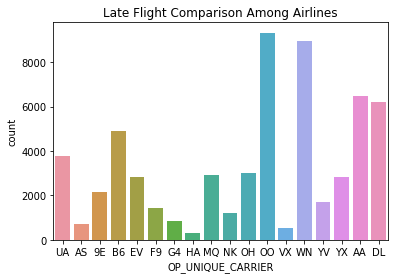

In [8]:
sns.countplot(df.OP_UNIQUE_CARRIER)
plt.title('Late Flight Comparison Among Airlines')

In [9]:
# Observing the correlations of features against target variable 'ARR_DELAY'
corr = df.corr()
corr['ARR_DELAY']

YEAR                        NaN
MONTH                       NaN
DAY_OF_MONTH          -0.026359
DAY_OF_WEEK            0.024540
OP_CARRIER_FL_NUM      0.039589
ORIGIN_AIRPORT_ID     -0.016280
DEST_AIRPORT_ID       -0.045060
CRS_DEP_TIME          -0.039337
DEP_TIME              -0.022185
DEP_DELAY              0.975909
DEP_DELAY_NEW          0.976621
TAXI_OUT               0.021021
TAXI_IN                0.029353
CRS_ARR_TIME          -0.033438
ARR_TIME              -0.067726
ARR_DELAY              1.000000
CANCELLED                   NaN
DIVERTED                    NaN
CRS_ELAPSED_TIME      -0.003918
ACTUAL_ELAPSED_TIME   -0.010121
AIR_TIME              -0.020655
DISTANCE              -0.014606
CARRIER_DELAY          0.654960
WEATHER_DELAY          0.359479
NAS_DELAY              0.199582
SECURITY_DELAY         0.019679
LATE_AIRCRAFT_DELAY    0.388424
Name: ARR_DELAY, dtype: float64

Unsurprisingly, it looks like the key feature in helping us identify the ARR_DELAY is going to be DEP_DELAY; moreover, there is a slightly higher correlation with DEP_DELAY_NEW. However, in order to simulate a real-life situation, we will drop the DEP_DELAY_NEW feature (under the assumption that this column is updated at the actual time of late departure) because then the model would be little more than a calculation of how long a flight takes to get from Point A to Point B.

In addition to this, we will also be dropping the YEAR (all are 2018), MONTH (all are January), CANCELLED, and DIVERTED features since they have no variability.

In [10]:
df = df.drop(['DEP_DELAY_NEW', 'YEAR', 'MONTH', 'CANCELLED','DIVERTED'], 1)

# Removing 8 NaN rows for consistency
df = df[~df.DEP_DELAY.isnull()]

In [11]:
df.nunique()

DAY_OF_MONTH             31
DAY_OF_WEEK               7
OP_UNIQUE_CARRIER        18
OP_CARRIER_FL_NUM      6213
ORIGIN_AIRPORT_ID       329
DEST_AIRPORT_ID         323
CRS_DEP_TIME           1134
DEP_TIME               1351
DEP_DELAY               938
TAXI_OUT                165
TAXI_IN                 127
CRS_ARR_TIME           1273
ARR_TIME               1414
ARR_DELAY               883
CRS_ELAPSED_TIME        434
ACTUAL_ELAPSED_TIME     512
AIR_TIME                473
DISTANCE               1349
CARRIER_DELAY           748
WEATHER_DELAY           493
NAS_DELAY               379
SECURITY_DELAY           81
LATE_AIRCRAFT_DELAY     483
dtype: int64

In [12]:
# Changing categorical variables into dummy variables
features = pd.concat([df.drop('DAY_OF_MONTH', axis=1), pd.get_dummies(df['DAY_OF_MONTH'], prefix='day')], axis=1)
features = pd.concat([features.drop('DAY_OF_WEEK', axis=1), pd.get_dummies(features['DAY_OF_WEEK'])], axis=1)
features = pd.concat([features.drop('OP_UNIQUE_CARRIER', axis=1), 
                      pd.get_dummies(features['OP_UNIQUE_CARRIER'], prefix='carrier')], axis=1)
features = features.rename({1: "sun", 2: "mon", 3: "tues", 4: "wed", 5: "thur", 6: "fri", 7: "sat"}, axis='columns')

In [13]:
features.shape

(60270, 76)

## Splitting Dataset into Training and Testing Sets

31.0

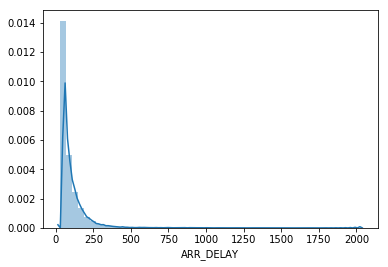

In [14]:
sns.distplot(features.ARR_DELAY)
features.ARR_DELAY.min()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features.drop('ARR_DELAY',1), 
                                                    features.ARR_DELAY,
                                                    test_size = 0.3)

## Model 1: Lasso Regression with All Features

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


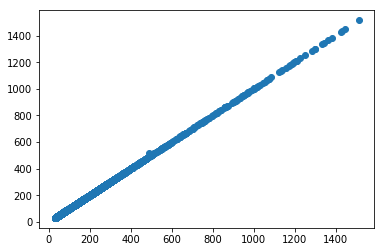


R-squared: 
 0.9999905041103303


In [16]:
# Using Lasso Regression to remove all features that don't provide insight
lasso = Lasso()
lasso.fit(X_train, y_train)

pred = lasso.predict(X_test)
plt.scatter(pred, y_test)
plt.show()
print('\nR-squared: \n', lasso.score(X_test, y_test))

In [17]:
lasso_features = pd.DataFrame()
lasso_features['features'] = X_train.columns[lasso.coef_ != 0]
lasso_features['coefficients'] = lasso.coef_[lasso.coef_ != 0]
lasso_features

,features,coefficients
0,OP_CARRIER_FL_NUM,-0.000005
1,ORIGIN_AIRPORT_ID,0.000005
2,DEST_AIRPORT_ID,-0.000004
3,DEP_TIME,-0.000022
4,DEP_DELAY,0.801534
5,TAXI_OUT,0.001867
6,CRS_ARR_TIME,-0.000007
7,ARR_TIME,-0.000003
8,CRS_ELAPSED_TIME,-0.789004
9,ACTUAL_ELAPSED_TIME,0.794554


As was estimated with the correlation matrix, the most valuable feature is DEP_DELAY - the initial estimate of how delayed a flight will be departing from the origin airport. Let's see how the same model performs without this feature.

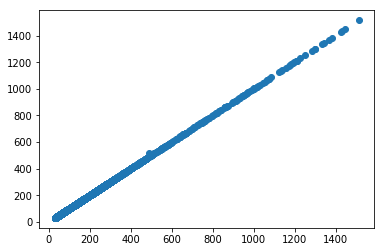


R-squared: 
 0.9999929824242648


In [18]:
lasso = Lasso()
lasso.fit(X_train.drop('DEP_DELAY', 1), y_train)

pred = lasso.predict(X_test.drop('DEP_DELAY', 1))
plt.scatter(pred, y_test)
plt.show()
print('\nR-squared: \n', lasso.score(X_test.drop('DEP_DELAY', 1), y_test))

In [19]:
lasso_features_2 = pd.DataFrame()
lasso_features_2['features'] = X_train.drop('DEP_DELAY', 1).columns[lasso.coef_ != 0]
lasso_features_2['coefficients'] = lasso.coef_[lasso.coef_ != 0]
lasso_features_2

,features,coefficients
0,OP_CARRIER_FL_NUM,8.219996e-07
1,ORIGIN_AIRPORT_ID,4.577734e-07
2,CRS_DEP_TIME,-3.443107e-06
3,CRS_ARR_TIME,-4.055116e-06
4,CARRIER_DELAY,9.997021e-01
5,WEATHER_DELAY,9.994331e-01
6,NAS_DELAY,9.990932e-01
7,SECURITY_DELAY,9.417414e-01
8,LATE_AIRCRAFT_DELAY,9.994943e-01


Interestingly, the amount of variance explained increases when removing the formerly most valuable feature. The reasoning for this is that now the lasso regression formula simply sets the coefficients of the types of delays to essentially **1** which means simple addition of these types of delays to calculate the total delay time. It is interesting that it didn't do this earlier though. Let's see how the model performs when these are stripped as well.

In [20]:
features_removed = list(lasso_features_2.features)
features_removed.append('DEP_DELAY')

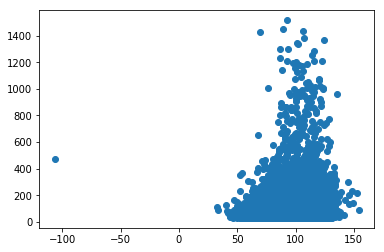


R-squared: 
 0.025777307458489274


In [21]:
lasso = Lasso()
lasso.fit(X_train.drop(features_removed, 1), y_train)

pred = lasso.predict(X_test.drop(features_removed, 1))
plt.scatter(pred, y_test)
plt.show()
print('\nR-squared: \n', lasso.score(X_test.drop(features_removed, 1), y_test))

That is wonderful. After removing the staple features of the model, the model is reduced to making a dookie.